In [2]:
from spectral import *
import cv2
import os
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from time import time

In [3]:
def load_one_img(hdr_file, bil_file):
    img = envi.open(hdr_file, bil_file)
    array = img.load()
    return np.array(array)

In [4]:
bands_file = 'C:/Data Processing/wave_length.txt'

bands = pd.read_csv(bands_file, header=None)
wavelength = bands[0].tolist()

In [5]:
bands_str = [str(item) for item in wavelength]

In [6]:
root_dir = "D:/Leaf_Project/09_09_2025/"
# filename = "Pathes.txt"
trainName ="train.txt"
testName ="test.txt"

In [7]:
def get_file_list(filename):
    pathes = []
    with open(filename, 'r') as file:
        lines = [line.strip() for line in file if line.strip()]
        for line in lines:
            full_path = root_dir + line + "/calibrations"
            pathes.append(full_path)

    return pathes


In [8]:
train_list = get_file_list(trainName)

In [9]:
test_list = get_file_list(testName)
test_list

['D:/Leaf_Project/09_09_2025/G0H_012_2025-09-10_20-57-16/calibrations',
 'D:/Leaf_Project/09_09_2025/G1_020_2025-09-10_18-33-16/calibrations',
 'D:/Leaf_Project/09_09_2025/G3_008_2025-09-10_20-11-19/calibrations',
 'D:/Leaf_Project/09_09_2025/G4_004_2025-09-10_16-14-39/calibrations',
 'D:/Leaf_Project/09_09_2025/G6_008_2025-09-10_21-39-36/calibrations']

In [10]:
str = 'D:/Leaf_Project/09_09_2025/G0H_016_2025-09-10_21-02-42/calibrations'
new_str = str[27:].split('_')[0]
new_str

'G0H'

In [11]:
def get_pathes(path_list):
    all_files = []
    for path in path_list:
        sub_pathes = []
        d_file = path + "/Dark.txt"
        w_file = path + "/White.txt"
        bip_file = glob.glob(path + "/*FromSelection.bip")
        hdr_file = bip_file[0] + ".hdr"
        label = path[27:].split('_')[0]
        sub_pathes.extend([d_file, w_file, hdr_file, bip_file[0],label])
        all_files.append(sub_pathes)
        
    return all_files


In [12]:
def get_img_vals(pathes):
    vals = []
    for files in pathes:
        dark = pd.read_csv(files[0], header=None, sep='\t')
        white = pd.read_csv(files[1], header=None, sep='\t')
        dark_np = dark[1].to_numpy()
        white_np = white[1].to_numpy()
        cube = load_one_img(files[2], files[3])
        val = (cube - dark_np)/(white_np - dark_np + 0.0001)
        vals.append([val, files[4]])
    return vals

In [13]:
train_path = get_pathes(train_list)
train_path[0]

['D:/Leaf_Project/09_09_2025/G0H_001_2025-09-10_20-46-09/calibrations/Dark.txt',
 'D:/Leaf_Project/09_09_2025/G0H_001_2025-09-10_20-46-09/calibrations/White.txt',
 'D:/Leaf_Project/09_09_2025/G0H_001_2025-09-10_20-46-09/calibrations\\G0H_001_FromSelection.bip.hdr',
 'D:/Leaf_Project/09_09_2025/G0H_001_2025-09-10_20-46-09/calibrations\\G0H_001_FromSelection.bip',
 'G0H']

In [14]:
train_vals = get_img_vals(train_path)

In [15]:
len(train_vals)

25

In [16]:
test_path = get_pathes(test_list)

In [17]:
test_vals = get_img_vals(test_path)

In [109]:
def convert_pd(np_list):
    pd_list = []
    for arr in np_list:
        reshaped_np = arr[0].reshape(-1, 448)
        _label = arr[1]
        _pd = pd.DataFrame(data = reshaped_np, columns=bands_str)
        _pd['label1'] = int(_label[1])  # 'G0H', 'G1',...
        if(_label[1] == '1'):
            _pd['label2'] = 0
        else:
            _pd['label2'] = 1

        pd_list.append(_pd)

    final_df = pd.concat(pd_list, ignore_index=True)

    return final_df

In [20]:
train_pd = convert_pd(train_vals)

In [21]:
test_pd = convert_pd(test_vals)

In [22]:
test_pd

,397.01,398.32,399.63,400.93,402.24,403.55,404.86,406.17,407.48,408.79,...,994.65,996.06,997.47,998.88,1000.29,1001.7,1003.11,1004.52,label1,label2
0,0.749981,0.499988,0.499988,0.999980,0.799984,-0.399992,0.799984,0.999983,0.000000,-0.285710,...,0.393938,0.176470,0.125000,0.193548,0.299999,0.333332,0.333332,0.333332,0,0
1,0.999975,0.999975,-0.999975,-0.599988,0.199996,-0.799984,0.000000,0.499992,0.142855,-0.857131,...,0.121212,0.058823,0.000000,0.161290,0.166666,0.000000,0.000000,0.000000,0,0
2,0.749981,0.749981,-0.249994,-0.799984,-0.199996,-0.399992,0.599988,-0.166664,-0.142855,0.000000,...,0.363635,0.147058,0.125000,0.193548,0.133333,-0.066666,-0.066666,-0.066666,0,0
3,-0.999975,-0.999975,-0.999975,-0.599988,0.000000,0.399992,0.599988,-0.333328,0.571420,0.857131,...,0.424241,0.088235,0.249999,0.193548,0.133333,0.199999,0.199999,0.199999,0,0
4,0.249994,0.249994,-0.249994,0.399992,-0.999980,-0.999980,0.599988,0.833319,0.142855,0.857131,...,0.181818,0.588234,0.312499,0.193548,0.100000,0.266666,0.266666,0.266666,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
311015,-1.249969,-1.249969,0.249994,0.499988,-0.499988,-0.999975,-1.399972,-0.999980,0.571420,0.714276,...,0.272726,0.151515,0.093750,0.032258,0.096774,0.137931,0.137931,0.137931,6,1
311016,-0.249994,-0.249994,0.749981,1.999950,1.999950,0.000000,-1.399972,0.399992,1.142841,0.428565,...,0.393938,0.424241,0.281249,0.161290,0.354838,0.448274,0.448274,0.448274,6,1
311017,2.499938,2.499938,0.000000,0.000000,0.000000,-1.499963,-0.399992,0.399992,1.428551,0.714276,...,0.212121,0.181818,0.218749,0.032258,0.096774,-0.172413,-0.172413,-0.172413,6,1
311018,1.749956,1.749956,-0.499988,-1.999950,-0.249994,1.249969,1.199976,-0.599988,-0.285710,0.142855,...,0.242424,0.121212,0.187499,0.064516,0.064516,0.103448,0.103448,0.103448,6,1


In [90]:
G0_files = get_file_list("G0.txt")
G1_files = get_file_list("G1.txt")
G3_files = get_file_list("G3.txt")
G4_files = get_file_list("G4.txt")
G6_files = get_file_list("G6.txt")

In [94]:
G0_files[-1:]

['D:/Leaf_Project/09_09_2025/G0H_012_2025-09-10_20-57-16/calibrations']

In [76]:
G0_train_vals = get_img_vals(get_pathes(G0_files[:-1]))
G0_test_vals = get_img_vals(get_pathes(G0_files[-1:]))

G1_train_vals = get_img_vals(get_pathes(G1_files[:-1]))
G1_test_vals = get_img_vals(get_pathes(G1_files[-1:]))

G3_train_vals = get_img_vals(get_pathes(G3_files[:-1]))
G3_test_vals = get_img_vals(get_pathes(G3_files[-1:]))

G4_train_vals = get_img_vals(get_pathes(G4_files[:-1]))
G4_test_vals = get_img_vals(get_pathes(G4_files[-1:]))

G6_train_vals = get_img_vals(get_pathes(G6_files[:-1]))
G6_test_vals = get_img_vals(get_pathes(G6_files[-1:]))

In [110]:
G0_pd_train = convert_pd(G0_train_vals)
G0_pd_test = convert_pd(G0_test_vals)

G1_pd_train = convert_pd(G1_train_vals)
G1_pd_test = convert_pd(G1_test_vals)

G3_pd_train = convert_pd(G3_train_vals)
G3_pd_test = convert_pd(G3_test_vals)

G4_pd_train = convert_pd(G4_train_vals)
G4_pd_test = convert_pd(G4_test_vals)

G6_pd_train = convert_pd(G6_train_vals)
G6_pd_test = convert_pd(G6_test_vals)

In [23]:
from sklearn.model_selection import train_test_split
#from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold

from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectKBest,f_classif,chi2

#from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel

from sklearn.feature_selection import RFECV

import xgboost as xgb
from sklearn.metrics import accuracy_score, f1_score, classification_report


In [99]:
final_train

,397.01,398.32,399.63,400.93,402.24,403.55,404.86,406.17,407.48,408.79,...,994.65,996.06,997.47,998.88,1000.29,1001.7,1003.11,1004.52,label1,label2
0,0.000000,0.000000,0.000000,-0.249994,0.000000,0.399992,-0.799984,-1.499975,0.571420,0.571420,...,0.272726,0.029412,0.125000,0.031250,0.100000,0.129032,0.129032,0.129032,0,0
1,1.249969,1.249969,0.000000,-1.499963,0.000000,-1.399972,0.199996,0.999983,0.142855,0.571420,...,0.121212,0.000000,-0.062500,0.406249,0.266666,0.064516,0.064516,0.064516,0,0
2,1.999950,1.999950,1.999950,-0.249994,-0.399992,0.399992,1.199976,0.999983,0.428565,0.428565,...,0.242424,0.117647,0.093750,0.125000,0.199999,0.161290,0.161290,0.161290,0,0
3,0.749981,0.749981,0.749981,0.249994,0.000000,1.399972,0.599988,0.333328,0.571420,0.428565,...,0.181818,0.117647,0.281249,0.249999,0.033333,0.258064,0.258064,0.258064,0,0
4,2.249944,2.249944,0.749981,-0.249994,0.599988,0.199996,1.199976,0.666656,0.285710,0.428565,...,0.181818,-0.117647,0.218749,0.281249,0.000000,-0.064516,-0.064516,-0.064516,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2095843,-0.666644,-0.666644,-0.333322,1.249969,0.249994,0.799984,0.333328,0.833319,0.833319,0.857131,...,0.264705,0.333332,0.562498,0.322580,0.399999,0.233333,0.233333,0.233333,6,1
2095844,-0.666644,-0.666644,-0.333322,0.249994,-1.249969,0.199996,0.499992,0.999983,1.166647,1.714261,...,0.382352,0.363635,0.406249,0.161290,0.266666,0.166666,0.166666,0.166666,6,1
2095845,3.333222,3.333222,0.666644,0.000000,-0.749981,0.199996,0.000000,0.833319,-0.499992,0.285710,...,0.058823,-0.030303,0.125000,0.129032,0.000000,-0.066666,-0.066666,-0.066666,6,1
2095846,2.666578,2.666578,0.999967,0.499988,0.000000,-0.199996,-0.833319,0.000000,0.166664,0.142855,...,0.382352,-0.030303,0.093750,0.322580,0.333332,0.299999,0.299999,0.333332,6,1


In [111]:
# train_lst = [G1_pd_train, G3_pd_train, G4_pd_train, G6_pd_train]
# test_lst = [G1_pd_test, G3_pd_test, G4_pd_test, G6_pd_test]

train_lst = [ G3_pd_train, G4_pd_train, G6_pd_train]
test_lst = [ G3_pd_test, G4_pd_test, G6_pd_test]

count = 1
G1_pd_train['label2'] = 0
G1_pd_test['label2'] = 0

for train, test in zip(train_lst, test_lst):
    train_pd_lst = [G1_pd_train]
    test_pd_lst = [G1_pd_test]
    train_pd_lst.append(train)
    test_pd_lst.append(test)
    final_train = pd.concat(train_pd_lst, ignore_index=True)
    final_test = pd.concat(test_pd_lst, ignore_index=True)
    train_random = final_train.sample(frac=1, random_state=42).reset_index(drop=True)
    test_random = final_test.sample(frac=1, random_state=42).reset_index(drop=True)
    
    X_train = train_random.drop(columns=['label1', 'label2'])  # All columns except 'label'
    # Only the 'label' column
    y2_train = train_random['label2']

    X_test = test_random.drop(columns=['label1', 'label2'])  # All columns except 'label'
    y2_test = test_random['label2']
    # 3. Initialize the Classifier
    # Note: If you have only 2 classes, you don't strictly need 'num_class' 
    # or 'multi:softmax', but this config works safely for 3+ classes too.
    # for label 1
    model = xgb.XGBClassifier(
        objective='binary:logistic',  # Use 'binary:logistic' if strictly 2 classes
        # num_class= len(y2_train.unique()),  # Automatically set number of classes
        tree_method="hist",         # Required for modern GPU support
        device="cuda",              # Activates NVIDIA GPU
        eval_metric='mlogloss'
    )
    
    # 4. Train the model
    print("Current: 0 V.S.", count)
    count+=1
    print("Training started...")
    model.fit(X_train, y2_train)
    print("Training complete!")

    # 5. Make Predictions
    predictions = model.predict(X_test)
    
    # 6. Check Accuracy
    acc = accuracy_score(y2_test, predictions)
    print(f"Accuracy: {acc * 100:.2f}%")
    
    # 7. Detailed Report
    # This shows precision, recall, and f1-score for each class
    print("\nClassification Report:")
    print(classification_report(y2_test, predictions))

Current: 0 V.S. 1
Training started...
Training complete!
Accuracy: 58.75%

Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.04      0.07     39208
           1       0.58      0.99      0.73     53369

    accuracy                           0.59     92577
   macro avg       0.67      0.51      0.40     92577
weighted avg       0.66      0.59      0.45     92577

Current: 0 V.S. 2
Training started...
Training complete!
Accuracy: 76.62%

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.75      0.75     39208
           1       0.78      0.78      0.78     45942

    accuracy                           0.77     85150
   macro avg       0.76      0.76      0.76     85150
weighted avg       0.77      0.77      0.77     85150

Current: 0 V.S. 3
Training started...
Training complete!
Accuracy: 84.09%

Classification Report:
              precision    recall  f1-score   suppor

In [24]:
# Shuffle 100% of the rows (frac=1)
train_random = train_pd.sample(frac=1, random_state=42).reset_index(drop=True)

In [25]:
test_random = test_pd.sample(frac=1, random_state=42).reset_index(drop=True)

In [26]:
_label1 = test_random['label1'].to_numpy()

count = np.count_nonzero(_label1 == 1)
count

39208

In [27]:
# 1. Separate Features (X) and Target (y)
X_train = train_random.drop(columns=['label1', 'label2'])  # All columns except 'label'
y1_train = train_random['label1']                 # Only the 'label' column
y2_train = train_random['label2']

X_test = test_random.drop(columns=['label1', 'label2'])  # All columns except 'label'
y1_test = test_random['label1']                 # Only the 'label' column
y2_test = test_random['label2']

In [28]:
from sklearn.preprocessing import LabelEncoder

# 1. Initialize the encoder
le = LabelEncoder()

# 2. Fit and Transform your labels
# This maps: 0->0, 1->1, 3->2, 4->3, 6->4
y_train = le.fit_transform(y1_train)
y_test  = le.fit_transform(y1_test)

In [29]:
# 3. Initialize the Classifier
# Note: If you have only 2 classes, you don't strictly need 'num_class' 
# or 'multi:softmax', but this config works safely for 3+ classes too.
# for label 1
model = xgb.XGBClassifier(
    objective='multi:softmax',  # Use 'binary:logistic' if strictly 2 classes
    num_class= 5, #len(y.unique()),  # Automatically set number of classes
    tree_method="hist",         # Required for modern GPU support
    device="cuda",              # Activates NVIDIA GPU
    eval_metric='mlogloss'
)

# 4. Train the model
print("Training started...")
model.fit(X_train, y_train)
print("Training complete!")

Training started...
Training complete!


In [30]:
# 5. Make Predictions
predictions = model.predict(X_test)

# 6. Check Accuracy
acc = accuracy_score(y_test, predictions)
print(f"Accuracy: {acc * 100:.2f}%")

# 7. Detailed Report
# This shows precision, recall, and f1-score for each class
print("\nClassification Report:")
print(classification_report(y_test, predictions))

C:\Users\minr1\CodingEnvironment\Python\Lib\site-packages\xgboost\core.py:774: UserWarning: [23:37:50] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:62: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


Accuracy: 64.17%

Classification Report:
              precision    recall  f1-score   support

           0       0.36      0.08      0.13     61435
           1       0.14      0.02      0.03     39208
           2       0.36      0.87      0.51     53369
           3       0.97      0.89      0.93     45942
           4       0.88      0.96      0.91    111066

    accuracy                           0.64    311020
   macro avg       0.54      0.56      0.50    311020
weighted avg       0.61      0.64      0.58    311020



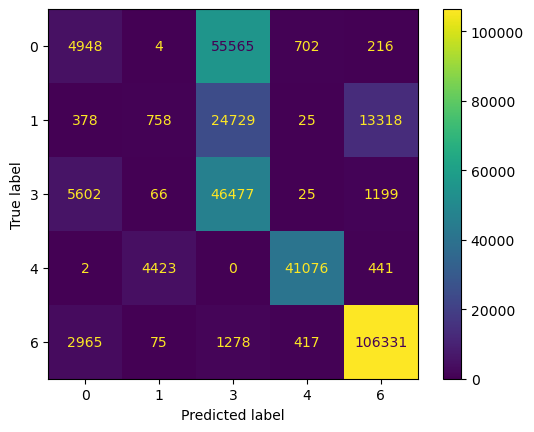

In [31]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Generate confusion matrix
cm = confusion_matrix(y_test, predictions)

# Visualize it
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot()
plt.show()

In [32]:
# 3. Initialize the Classifier
# Note: If you have only 2 classes, you don't strictly need 'num_class' 
# or 'multi:softmax', but this config works safely for 3+ classes too.
# for label 1
model = xgb.XGBClassifier(
    objective='binary:logistic',  # Use 'binary:logistic' if strictly 2 classes
    # num_class= len(y2_train.unique()),  # Automatically set number of classes
    tree_method="hist",         # Required for modern GPU support
    device="cuda",              # Activates NVIDIA GPU
    eval_metric='mlogloss'
)

# 4. Train the model
print("Training started...")
model.fit(X_train, y2_train)
print("Training complete!")

Training started...
Training complete!


In [33]:
# 5. Make Predictions
predictions = model.predict(X_test)

# 6. Check Accuracy
acc = accuracy_score(y_test, predictions)
print(f"Accuracy: {acc * 100:.2f}%")

# 7. Detailed Report
# This shows precision, recall, and f1-score for each class
print("\nClassification Report:")
print(classification_report(y2_test, predictions))

Accuracy: 12.98%

Classification Report:
              precision    recall  f1-score   support

           0       0.34      0.02      0.04     61435
           1       0.80      0.99      0.89    249585

    accuracy                           0.80    311020
   macro avg       0.57      0.51      0.46    311020
weighted avg       0.71      0.80      0.72    311020



In [38]:
estimators = [
    ('QuadraticDiscriminantAnalysis',QuadraticDiscriminantAnalysis(reg_param=0.01)),
    ('RandomForestClassifier', RandomForestClassifier(n_estimators=10, random_state=42)),
    ('KNeighborsClassifier',KNeighborsClassifier(n_neighbors=3)),
    ('GaussianNB',GaussianNB()),
    ('AdaBoostClassifier',AdaBoostClassifier()),
    ('DecisionTreeClassifier',DecisionTreeClassifier()),
    #('SVC', SVC()),
]

In [39]:
for item in estimators:
    name = item[0]
    clf  = item[1]
    t0 = time()
    clf = clf.fit(X_train, y_train)
    
    # Make predictions on the test set
    y_pred = clf.predict(X_test)
    _score = accuracy_score(y_test,y_pred)

    # Evaluate the classification performance
    #print(classification_report(y_test, y_pred))
    print("Model {} get {}".format(name, _score))

    
    print("using {} seconds".format(time()-t0))
    

Model QuadraticDiscriminantAnalysis get 0.32295350781300236
using 42.12389063835144 seconds
Model RandomForestClassifier get 0.44322873127130086
using 243.06334042549133 seconds


C:\Users\minr1\CodingEnvironment\Python\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] 系统找不到指定的文件。
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\minr1\CodingEnvironment\Python\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
        "wmic CPU Get NumberOfCores /Format:csv".split(),
        capture_output=True,
        text=True,
    )
  File "C:\Users\minr1\CodingEnvironment\Python\Lib\subprocess.py", line 554, in run
    with Popen(*popenargs, **kwargs) as process:
         ~~~~~^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\minr1\CodingEnvironment\Python\Lib\subprocess.py", line 1039, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
    ~~~~~~~

Model KNeighborsClassifier get 0.22854478811651985
using 1552.72323179245 seconds
Model GaussianNB get 0.283515529547939
using 13.308433532714844 seconds
Model AdaBoostClassifier get 0.3838209761430133
using 1713.584175825119 seconds
Model DecisionTreeClassifier get 0.2893222300816668
using 882.6588439941406 seconds
